In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import keras.backend as K
from keras import regularizers
import keras_tuner as kt
from keras.utils.vis_utils import plot_model
from multi_label_metrics import *
from sklearn.calibration import calibration_curve
from BM import bm_counter
import tensorflow_probability as tfp
from sklearn.isotonic import IsotonicRegression
from stellargraph.calibration import TemperatureCalibration, IsotonicCalibration
from stellargraph.calibration import plot_reliability_diagram, expected_calibration_error
from calibration_module.calibrator import (
    HistogramCalibrator,
    PlattCalibrator,
    PlattHistogramCalibrator
)
from label_info import label_counter

In [2]:
#fix the random seed for comparison
from numpy.random import seed
seed(11)
from tensorflow.random import set_seed
set_seed(22)

data,_ = arff.loadarff('scene.arff')
df = pd.DataFrame(data) 
df=df.sample(frac=1,random_state =1) #shuffle the data
rows,cols = df.shape
df.head()


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Beach,Sunset,FallFoliage,Field,Mountain,Urban
2406,0.974915,0.866425,0.818144,0.936140,0.938583,0.935087,0.930597,1.000000,0.806074,0.717955,...,0.073742,0.005131,0.025059,0.004033,b'0',b'0',b'0',b'0',b'0',b'1'
2352,0.697012,0.760710,0.797416,0.858690,0.822442,0.720807,0.810469,0.620843,0.729764,0.783508,...,0.140970,0.115399,0.023692,0.044930,b'0',b'0',b'0',b'0',b'0',b'1'
2211,0.983764,0.991638,0.918196,0.908769,0.893647,0.843644,0.684601,1.000000,0.988726,0.885405,...,0.226596,0.162894,0.067569,0.067359,b'0',b'0',b'0',b'0',b'0',b'1'
1994,0.986745,0.986901,0.979224,0.980285,0.979826,0.951972,0.931917,0.986359,0.986667,0.986823,...,0.014017,0.012063,0.044558,0.027307,b'0',b'0',b'0',b'1',b'0',b'0'
2347,0.703788,0.739319,0.758098,0.762952,0.758033,0.741663,0.711662,0.741278,0.775669,0.815994,...,0.159946,0.192540,0.008348,0.017899,b'0',b'0',b'0',b'0',b'0',b'1'


In [3]:
split_index = int(rows * 0.8)
data_train:pd.DataFrame = df.iloc[:split_index,:]
data_test:pd.DataFrame = df.iloc[split_index:,:]
x_train = np.array(data_train.iloc[:,:-6].values,dtype ='float32')
y_train = np.array(data_train.iloc[:,-6:].values,dtype ='int')
x_test = np.array(data_test.iloc[:,:-6].values,dtype ='float32')
y_test = np.array(data_test.iloc[:,-6:].values,dtype ='int')

X = np.concatenate((x_train,x_test))
Y = np.concatenate((y_train,y_test))
label_info = label_counter(X,Y)

for l in range(len(label_info)):
    print("Number of instances with %s positive label(s): %s" %(l,label_info[l].astype("int32")))



Number of instances with 0 positive label(s): 0
Number of instances with 1 positive label(s): 2230
Number of instances with 2 positive label(s): 176
Number of instances with 3 positive label(s): 1
Number of instances with 4 positive label(s): 0
Number of instances with 5 positive label(s): 0
Number of instances with 6 positive label(s): 0


In [4]:
#Build the network with Keras and Tuner for units number
from keras.layers import Input,Dense
input_dim = cols-6
output_dim = 6
def build_model(hp):
    #hp = hyperparamters to be modified
    model = Sequential()
    model.add(Dense(hp.Int('units_1',min_value = 200,max_value = 500,step=50),input_dim=input_dim,activation='relu'))
    model.add(Dense(hp.Int('units_2',min_value = 100,max_value = 300,step=50),activation='relu'))
    model.add(Dense(hp.Int('units_3',min_value=40,max_value=100,step=20),activation='relu'))
    model.add(Dense(output_dim,activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['binary_accuracy',hamming_loss,precision_micro,recall_micro,f1_micro])
    return model

In [5]:
#Build Tuner 
tuner = kt.RandomSearch(
    build_model,
    kt.Objective("hamming_loss", direction="min"), #optimization objective is binary accuracy, for fault diagnosis can also be recall rate
    max_trials = 20,
    executions_per_trial = 2,
    overwrite = True,
    project_name="Scene_Tuner")

Trial 20 Complete [00h 00m 16s]
hamming_loss: 0.01737475860863924

Best hamming_loss So Far: 0.006107010645791888
Total elapsed time: 00h 05m 09s
INFO:tensorflow:Oracle triggered exit


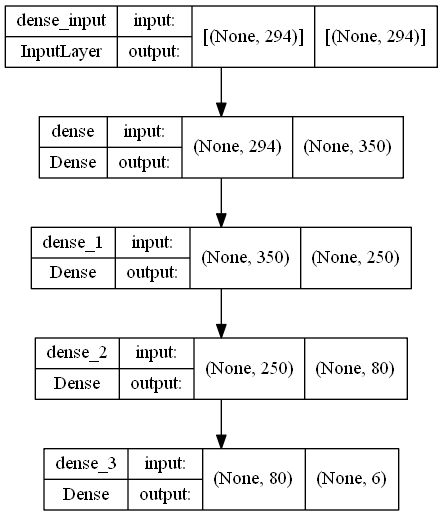

In [6]:
#get the best model with tuner
tuner.search(x_train,y_train, epochs = 60,batch_size = 256, validation_split=0.25,shuffle=True,verbose=1)
best_model = tuner.get_best_models()[0]
plot_model(best_model, to_file='./best_model_scene.png', show_shapes=True)

In [7]:
#evaluate the best_model with test data
loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro = best_model.evaluate(x_test, y_test)
print('Test:')
print('Loss: %s\nBinary-Accuracy(the same as Micro-Accuracy): %s \nHamming_Loss: %s \nMicro-Precision: %s \nMicro-Recall: %s \nMicro-F1 Score: %s' % (loss, accuracy,hamming_loss,precision_micro,recall_micro,f1_micro))

16/16 [==============================] - 1s 4ms/step - loss: 0.4085 - binary_accuracy: 0.9101 - hamming_loss: 0.0944 - precision_micro: 0.7450 - recall_micro: 0.7167 - f1_micro: 0.7294
Test:
Loss: 0.40852540731430054
Binary-Accuracy(the same as Micro-Accuracy): 0.9100968241691589 
Hamming_Loss: 0.0944010391831398 
Micro-Precision: 0.7450008988380432 
Micro-Recall: 0.7166794538497925 
Micro-F1 Score: 0.729378879070282


In [8]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 350)               103250    
                                                                 
 dense_1 (Dense)             (None, 250)               87750     
                                                                 
 dense_2 (Dense)             (None, 80)                20080     
                                                                 
 dense_3 (Dense)             (None, 6)                 486       
                                                                 
Total params: 211,566
Trainable params: 211,566
Non-trainable params: 0
_________________________________________________________________


In [9]:
y_pred = best_model.predict(x_test) 
predictions = (y_pred > 0.5).astype("int32")

In [10]:
recall_macro(y_test,predictions)

(array([0.73076923, 0.80769231, 0.74683544, 0.80232558, 0.56730769,
        0.75      ]),
 0.7341550425337591)

In [11]:
precision_macro(y_test,predictions)


(array([0.74025974, 0.96923077, 0.78666667, 0.84146341, 0.66292135,
        0.64485981]),
 0.774233625365007)

In [12]:
f1_macro(y_test,predictions)

(array([0.73548387, 0.88111888, 0.76623377, 0.82142857, 0.61139896,
        0.69346734]),
 0.7515218983604912)

In [13]:
accuracy_each_label(y_test,predictions)


array([0.91493776, 0.96473029, 0.9253112 , 0.93775934, 0.84439834,
       0.87344398])

In [14]:
np.mean(accuracy_each_label(y_test,predictions))

0.9100968188105117

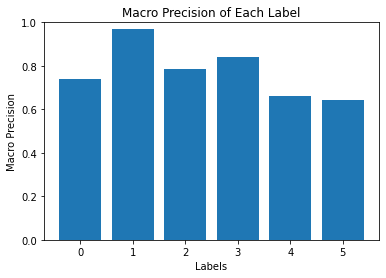

In [15]:
plt.bar(range(6),precision_macro(y_test,predictions)[0])
plt.ylim((0, 1))
plt.title('Macro Precision of Each Label')
plt.ylabel('Macro Precision')
plt.xlabel('Labels')
plt.savefig("./scene_macro_precision.jpg" )

"""Comparison of the average y_pred(float) i.e. confidence and the accuracy 
e.g. Reliability Diagrams to show the over-confidence problem
then uncertainty estimation methods
"""


In [16]:
#calibration 
data_val:pd.DataFrame = data_train.iloc[:int(split_index*1),:] #all the train data used for isotonic, logic described by Zadro, 
x_val = np.array(data_val.iloc[:,:-6].values,dtype ='float32')
y_val = np.array(data_val.iloc[:,-6:].values,dtype ='int')

In [17]:
y_val_pred = (best_model.predict(x_val))

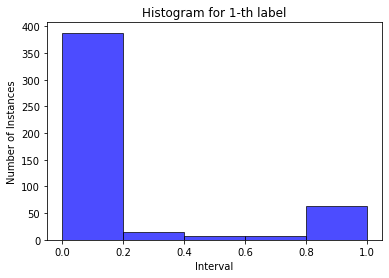

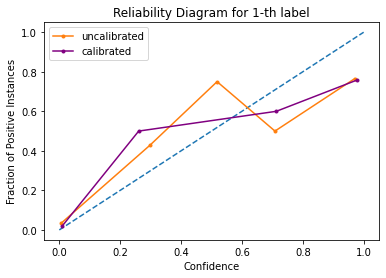

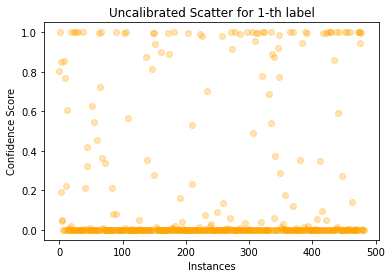

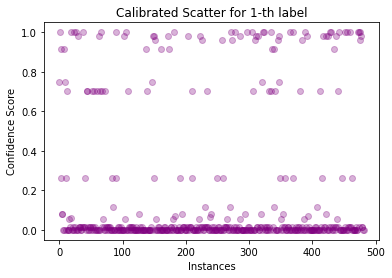

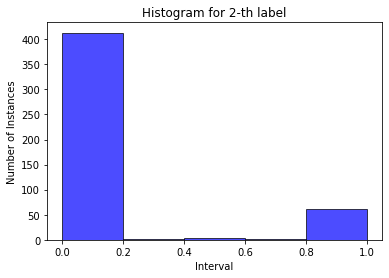

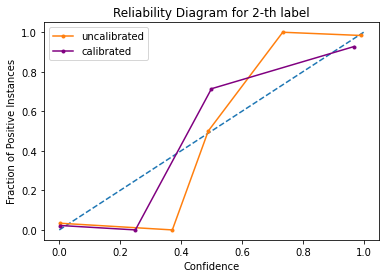

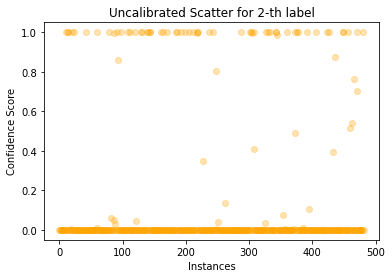

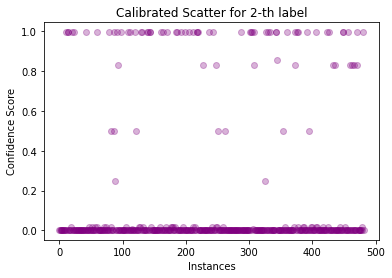

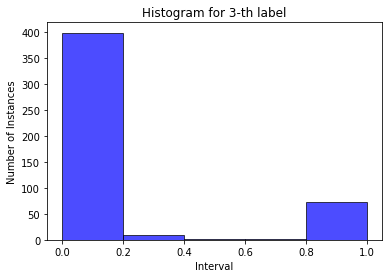

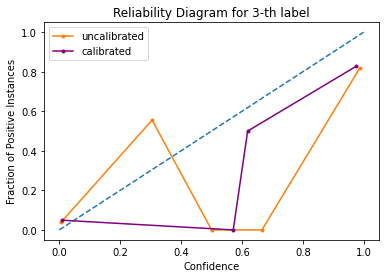

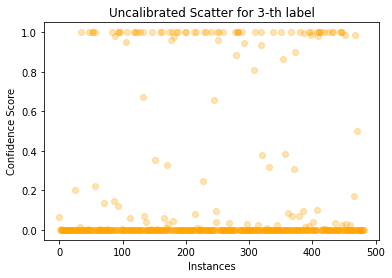

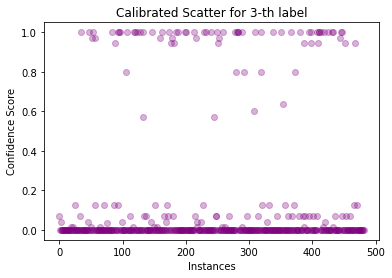

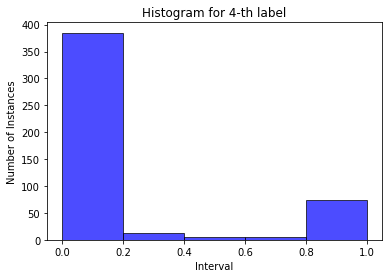

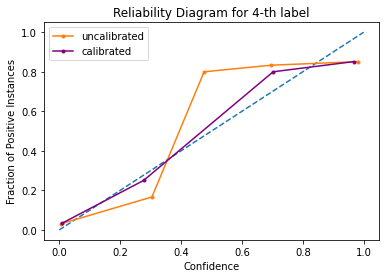

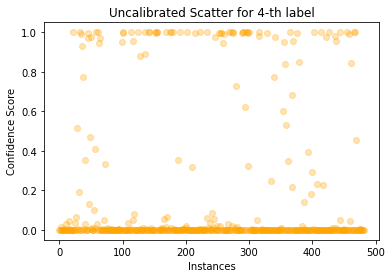

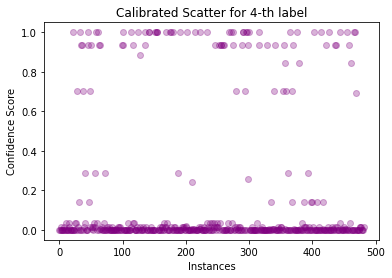

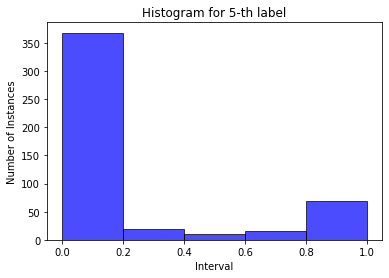

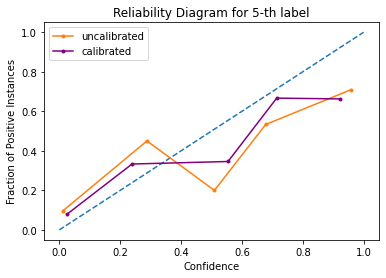

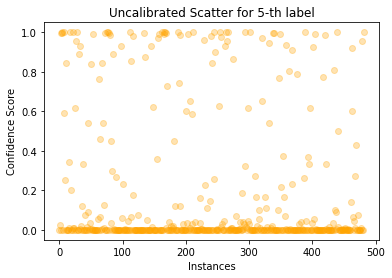

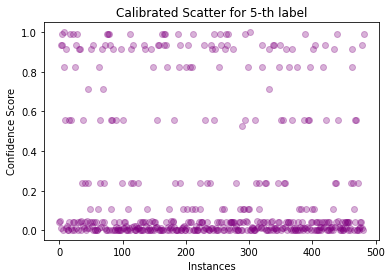

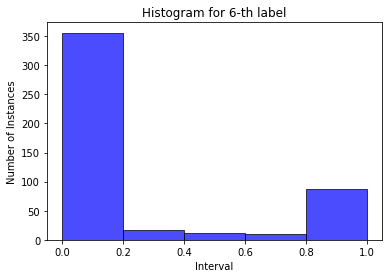

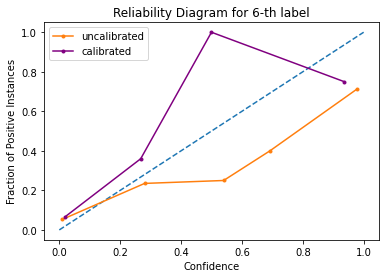

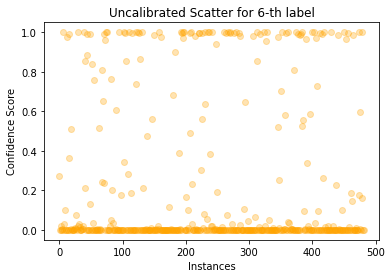

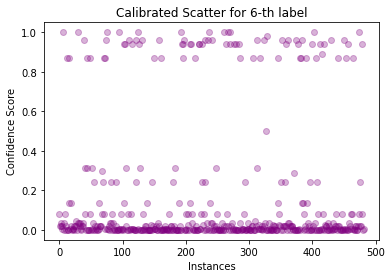

Expected Calibration Error for each label = [0.060630153622409005, 0.03153341677251923, 0.060561192467757825, 0.048878226472368905, 0.11836547996034369, 0.09480137570027052]
Expected Calibration Error for each label after Calibration = [0.050560699482119935, 0.025746828019503048, 0.05697197478681926, 0.04042320483541929, 0.10131294697356948, 0.0724707180107917]
Average Expected Calibration Error for all labels = 0.06912830749927819
Average Expected Calibration Error for all labels after Calibration = 0.05791439535137045


In [18]:
#Histograms of predictive value and reliability diagrams to show non-calibration 
ECE=[]
ECE_cal = []
calibrated_predictions =[]
bins =5
for i in range(np.shape(y_test)[1]):
    #val set for isotonic and train the isotonic model 
    ir = IsotonicRegression(out_of_bounds='clip',y_min=0,y_max=1)
    prob_val_true,prob_val_pred = calibration_curve(y_val[:,i],y_val_pred[:,i],n_bins=bins)
    ir.fit(y_val_pred[:,i],y_val[:,i])
    
    #histogram
    plt.hist(y_pred[:,i],bins = bins,range=(0,1),facecolor="blue", edgecolor="black", alpha=0.7)
    plt.title('Histogram for %s-th label' %(i+1))
    plt.ylabel('Number of Instances')
    plt.xlabel('Interval')
    plt.savefig("./scene_hist_%s.jpg" %(i+1))
    plt.show()
    
    #reliability diagram
    prob_true, prob_pred = calibration_curve(y_test[:,i], y_pred[:,i], n_bins=bins) #acc for each bin, avg pred for each bin 
    Bm = bm_counter(y_pred[:,i],bins)
    Bm = Bm[Bm != 0]
    temp_ece=np.sum(abs(prob_pred - prob_true)*Bm)/np.shape(y_pred)[0]
    ECE.append(temp_ece)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(prob_pred, prob_true, marker='.',label = 'uncalibrated')
    
    #calibration with isotonic regression
    
    #iso for each label
    y_pred_cal = np.array(ir.predict(y_pred[:,i]),dtype="float32")
    calibrated_predictions.append((y_pred_cal>0.5).astype("int32"))
    prob_true_cal, prob_pred_cal = calibration_curve(y_test[:,i],y_pred_cal, n_bins = bins)
    Bm_cal = bm_counter(y_pred_cal,bins)
    Bm_cal = Bm_cal[Bm_cal!=0]
    temp_ece_cal=np.sum(abs(prob_pred_cal - prob_true_cal)*Bm_cal)/np.shape(y_pred_cal)[0]
    ECE_cal.append(temp_ece_cal)
    plt.plot(prob_pred_cal,prob_true_cal, marker='.',color = "purple", label='calibrated')
    plt.title('Reliability Diagram for %s-th label' %(i+1))
    plt.ylabel('Fraction of Positive Instances')
    plt.xlabel('Confidence')
    plt.legend()
    plt.savefig("./scene_rd_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    #comparison of scatter before and after calibration
    plt.scatter(range(np.shape(y_pred)[0]),y_pred[:,i],color = "orange",label = ' uncalibrated',alpha= 0.3)
    plt.title('Uncalibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./scene_scatter_uncal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
    
    plt.scatter(range(np.shape(y_pred_cal)[0]),y_pred_cal,color = "purple",label = 'calibrated',alpha = 0.3)
    plt.title('Calibrated Scatter for %s-th label' %(i+1))
    plt.ylabel('Confidence Score')
    plt.xlabel('Instances')
    plt.savefig("./scene_scatter_cal_%s.jpg" %(i+1),bbox_inches="tight")
    plt.show()
calibrated_predictions = np.array(calibrated_predictions).T
print('Expected Calibration Error for each label = %s' %ECE)
print('Expected Calibration Error for each label after Calibration = %s' %ECE_cal)
avg_ECE = np.mean(ECE)
avg_ECE_cal= np.mean(ECE_cal)
print('Average Expected Calibration Error for all labels = %s' %avg_ECE)
print('Average Expected Calibration Error for all labels after Calibration = %s' %avg_ECE_cal)